**pip 및 import**

⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️

In [6]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas
from google.colab import files

import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random

**"서울시대로변횡단보도위치정보.csv" LINK와 NODE를 전처리**

⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️

In [4]:
#f = files.upload()

In [5]:
data = pandas.read_csv("서울시대로변횡단보도위치정보.csv", encoding="euc-kr")

data = data.loc[:, ["노드링크 유형", "노드 WKT", "링크 WKT", "시군구명", "읍면동명"]]
data["좌표"] = 0

for i, d in enumerate(data["노드 WKT"]):
  if(type(d) == str):
    data["좌표"][i] = d[6:-1]
  
for i, d in enumerate(data["링크 WKT"]):
  if(type(d) == str):
    data["좌표"][i] = d[11:-1]

data = data.drop(["노드 WKT", "링크 WKT"], axis = 1)

<ipython-input-5-e1393d7db171>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["좌표"][i] = d[6:-1]


In [5]:
data.to_csv("result.csv", encoding="euc-kr")
#files.download("result.csv")

tmp = []

for i, d in enumerate(data["좌표"]):
  tmp2 = []
  tmp2.append(float(d.split()[0]))
  tmp2.append(float(d.split()[1].split(",")[0]))
  tmp.append(tmp2)

real = np.array(tmp)

NameError: ignored

**MCLP 사용**

⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️

In [9]:
def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2)
        M: the number of candidate sites to generate
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

def mclp(points,K,radius,M):
    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(points,M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [4]:
# Plot input data
plot_input(real)

# Number of sites to select
K = 20

# Service radius of each site
radius = 0.2

# Candidate site size (random sites generated)
M = 100

# Run mclp opt_sites is the location of optimal sites and f is the points covered
opt_sites,f = mclp(real,K,radius,M)

# Plot the result
plot_result(real,opt_sites,radius)

NameError: ignored

In [8]:
f = files.upload()

Saving 광진구 횡단보도 좌표 중앙값 처리.csv to 광진구 횡단보도 좌표 중앙값 처리.csv


In [32]:
data = pandas.read_csv("광진구 횡단보도 좌표 중앙값 처리.csv", encoding="euc-kr")

tmp = []

for i in range(1010):
  tmp2 = []
  tmp2.append(data["경도"][i])
  tmp2.append(data["위도"][i])
  tmp.append(tmp2)
  

real = np.array(tmp)

----- Configurations -----
  Number of points 1010
  K 20
  Radius 0.2
  M 100
----- Output -----
  Running time : 0.16037225723266602 seconds
  Optimal coverage points: 1010


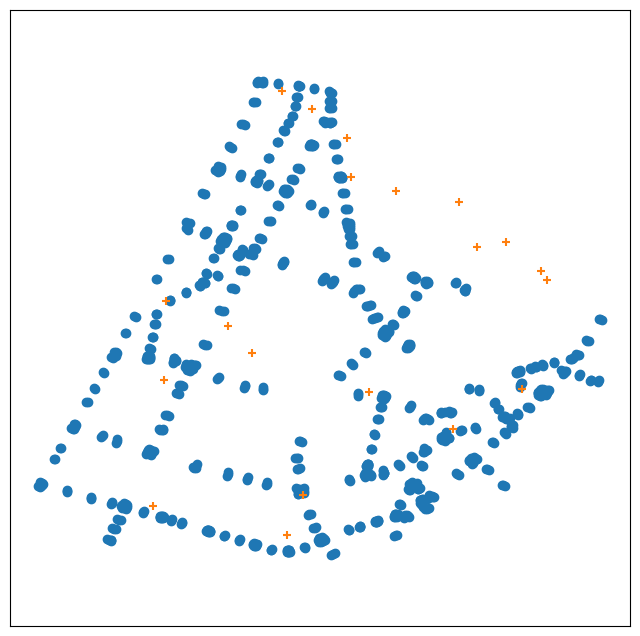

In [33]:
# Number of sites to select
K = 20

# Service radius of each site
radius = 0.2

# Candidate site size (random sites generated)
M = 100

# Run mclp opt_sites is the location of optimal sites and f is the points covered
opt_sites,f = mclp(real,K,radius,M)

# Plot the result
plot_result(real,opt_sites,radius)